In [ ]:
# python libraries
import pandas as pd
from pandasql import sqldf
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2

In [ ]:
df = pd.read_pickle('game_state_frame_data.pickle')

In [61]:
class ProcessGameState:
    def __init__(self, boundary, inventory):
        self.boundary = boundary
        self.inventory = inventory

    # File ingestion
    file = pd.read_pickle('game_state_frame_data.pickle')

    # is the given coordinates in the boundary (helper)
    # used numpy to prevent "Truth value of a Series is ambiguous" error in pandas
    # I used the shapely library to help me determine whether a coordinate (a point) is in the boundary (a polygon).
    # With this library I can easily set up a point (the coordinate), a polygon (the boundary), and use the contains() method to find whether the given point is in the polygon
    def inBoundary(x, y, z):
        points = [Point(xi, yi) for xi, yi in zip(x, y)]
        boundary = Polygon([(-1735, 250), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565, 580)])
        in_range = np.logical_and(285 <= z, z <= 421)
        inside_boundary = [boundary.contains(point) for point in points]
        result = np.where(np.logical_and(in_range, inside_boundary), 'Yes', 'No')
        return result
    
    # return a data frame that shows which rows are in the boundary and which are not
    boundary = file.filter(['side', 'team', 'x', 'y', 'z', 'area_name', 'seconds', 'map_name', 'player'])
    boundary['inBoundary'] = inBoundary(boundary.x, boundary.y, boundary.z)

    # Extract the weapon classes from the inventory json column
    inventory = file.filter(['area_name', 'side', 'team', 'clock_time', 'inventory'])
    inventory.dropna(inplace=True)
    inventory.reset_index(drop=True, inplace=True)

    for i in range(0, len(inventory)):
        newVal = (inventory.loc[i][4])[0]
        inventory.loc[i][4] = json.dumps(newVal)

    # add a new column in the dataframe called "weapon_class"
    inventory['weapon_class'] = inventory.apply(lambda x: json.loads(x['inventory'])['weapon_class'], axis = 1)
    


In [84]:
# 2a. Is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?
team2Tstrat = ProcessGameState.boundary
team2Tstrat.loc[(team2Tstrat['team'] == 'Team2') & (team2Tstrat['side'] == 'T')]
print(team2Tstrat['inBoundary'].value_counts(normalize=True) * 100)

# based on the printed answer, the answer to question a would be no. In fact, it shows that Team2 on T rarely enters via the light blue boundary. 

inBoundary
No     99.624091
Yes     0.375909
Name: proportion, dtype: float64


In [83]:
# b. What is the average timer that Team2 on T (terrorist) side enters “BombsiteB” with least 2 rifles or SMGs?
team2tavg = ProcessGameState.inventory
team2tavg.loc[(team2tavg['team'] == 'Team2') & (team2tavg['side'] == 'T')]

query = """SELECT clock_time, COUNT(*) AS counter
FROM (SELECT clock_time, weapon_class FROM team2tavg WHERE area_name = 'BombsiteB' AND (weapon_class = 'Rifle' OR weapon_class =  'SMG')
ORDER BY clock_time ASC)
GROUP BY clock_time
"""
t2tavg = sqldf(query)
print(t2tavg.to_string())

# based on the printed dataframe, the avereage time that Team2 on T enters "BOmbsiteB" with at least 2 rifles or SMGS is around 1 - 1:30

    clock_time  counter
0        00:00        7
1        00:01        4
2        00:02        2
3        00:03        4
4        00:04        2
5        00:05        5
6        00:06        8
7        00:07        4
8        00:08        2
9        00:09        9
10       00:10        8
11       00:11        4
12       00:12        3
13       00:13        4
14       00:14        6
15       00:15        3
16       00:16        5
17       00:17        3
18       00:18        7
19       00:19       11
20       00:20        8
21       00:21        9
22       00:22       12
23       00:23       17
24       00:24       22
25       00:25       15
26       00:26       21
27       00:27       15
28       00:28        7
29       00:29       14
30       00:30       19
31       00:31       12
32       00:32       17
33       00:33       12
34       00:34       17
35       00:35       14
36       00:36       16
37       00:37        7
38       00:38       12
39       00:39       12
40       00:40  

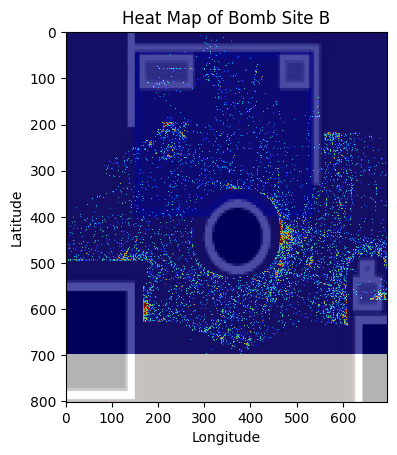

In [85]:
# c. Now that we’ve gathered data on Team2 T side, let's examine their CT (counter-terrorist) Side. Using the same data set, tell our coaching staff where you suspect them to be waiting inside “BombsiteB”
# heatmap over time against tick when team2 is on ct
team2CtStrat = ProcessGameState.boundary
team2CtStrat.loc[(team2CtStrat['team'] == 'Team2') & (team2CtStrat['side'] == 'CT')]

# SELECT data for frequency at each coordinate
query = """SELECT x, y, COUNT(*) AS freq FROM (SELECT DISTINCT x, y, seconds, player FROM team2CtStrat WHERE area_name = 'BombsiteB') GROUP BY x, y"""
t2ctbs = sqldf(query)

def heat_map():
    # initialize matrix
    model = np.zeros((697, 801), dtype=int)
    for t in range(0, len(t2ctbs)):
        x = (t2ctbs.iloc[t].at['x'] + 1362)
        y = (t2ctbs.iloc[t].at['y'] + 304)
        model[x,y] += 1
    return model

model = heat_map()
plt.imshow(model,cmap='jet', vmin=0, vmax=0.5)
plt.title("Heat Map of Bomb Site B")
plt.xlabel("Longitude")
plt.ylabel("Latitude")  
image = cv2.imread('bombsiteb.png')
imS = cv2.resize(image, (697, 801))              
plt.imshow(imS, alpha=0.3)

# -666     496 (upper right)
# -666    -305 (bottom right)
# -1363    -305 (bottom left)
# -1363     496 (upper left)

# I suspect them to be waiting behind the pillar (right side of the pillar in the orientation below) or bottom left of Bombsite B (near the canal)

In [ ]:
# 3. (No Coding) Most of the time, our stakeholders (in this case, the CS:GO 
#coaching staff) aren’t tech-savvy enough to run code themselves. Propose a solution to your product manager that:
# a. could allow our coaching staff to request or acquire the output themselves
# b. takes less than 1 weeks worth of work to implement

# I would propose creating a GUI that allows a intuitive interaction between the stakeholders and the product. More specifically,
# a web app could solve this issue by implementing a simple dashboard of some sort , for example, using the Django framework